In [10]:
!pip install -U langchain langchain_groq langchain_community langgraph tavily-python

In [12]:
import os
from google.colab import userdata
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [13]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages:Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=2)

tools = [tavily_tool]



In [16]:
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode, tools_condition

llm = ChatGroq(model="llama-3.2-90b-text-preview")
llm_with_tool = llm.bind_tools(tools)

def chatbot(state:State):
  print(state["messages"])
  return {"messages":[llm_with_tool.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools","chatbot")


In [17]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

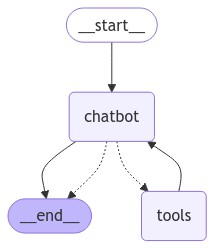

In [18]:
from IPython.display import display, Image
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
from langchain_core.messages import BaseMessage

while True:
  user_input = input("User:")

  if user_input.lower() in ["quit","q","exit"]:
    print("Goodebye!")
    break
  for event in graph.stream({"messages":[("user", user_input)]}):
    for value in event.values():
      if isinstance(value["messages"][-1], BaseMessage):
        print("Assistant:", value["messages"][-1].content)

User:Who is Ilma Salsabil?
[HumanMessage(content='Who is Ilma Salsabil?', additional_kwargs={}, response_metadata={}, id='7b386279-7ed6-474e-a933-52370da815ec')]
Assistant: <function=tavily_search_results_json>{"query": "Ilma Salsabil"}<function>
User:what is the weather in bangladesh?
[HumanMessage(content='what is the weather in bangladesh?', additional_kwargs={}, response_metadata={}, id='0b0ac8bd-8aa4-431b-a16d-062754d06980')]
Assistant: 
Assistant: [{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Dhaka', 'region': '', 'country': 'Bangladesh', 'lat': 23.723, 'lon': 90.409, 'tz_id': 'Asia/Dhaka', 'localtime_epoch': 1729241683, 'localtime': '2024-10-18 14:54'}, 'current': {'last_updated_epoch': 1729241100, 'last_updated': '2024-10-18 14:45', 'temp_c': 32.3, 'temp_f': 90.1, 'is_day': 1, 'condition': {'text': 'Partly Cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 3.4, 'wind_kph': 5.4, 'wind_degree': 80, 'wind_dir'